## Audio Classification
### Urban Sound Classification

In [1]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display
import pandas as pd
import soundfile as sf
import warnings
import random
from tqdm.auto import tqdm
pd.set_option('display.max_colwidth', None) # show full content of each cell

warnings.filterwarnings("ignore")

import tensorflow as tf 
from tensorflow.keras import layers, models 
from tensorflow.keras.preprocessing import image_dataset_from_directory 
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.applications import MobileNetV2, ResNet50 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau 
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image


# Classic ML Libraries 
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.preprocessing import StandardScaler 
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.cluster import KMeans 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, roc_curve, auc, f1_score
from skimage.transform import resize
from xgboost import XGBClassifier
import cv2  
import glob

In [2]:
import kagglehub

if not os.path.exists("urbansound8k"):
    path = kagglehub.dataset_download("chrisfilo/urbansound8k")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Shaurya\.cache\kagglehub\datasets\chrisfilo\urbansound8k\versions\1


In [3]:
RANDOM_SEED = 126233 
us_path = path + "\\UrbanSound8K.csv"
ubsound8k_df = pd.read_csv(us_path)
display(ubsound8k_df.head())

slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing

# Data Preprocessing and EDA related Functions

In [4]:
#Cleaning the dataset

def dataset_cleaning(df, path):
    df = df.drop(columns=["salience", "start", "end", "fsID"])
    df['file_path'] = df.apply(
        lambda row: os.path.join(path, f"fold{row['fold']}", row['slice_file_name']),
        axis=1
    )
    return df

def print_section():
    length = 240
    print("\n" + "=" * length)
    print("=" * length + "\n")


 
#Play audio

def play_audio(file_path):
    audio, sr = librosa.load(file_path, sr=None)
    print(f"Playing: {file_path}")
    display(ipd.Audio(audio, rate=sr))
    return audio, sr  


# Plot waveform
def plot_waveform(audio, sr, title="Waveform"):
    
    plt.figure(figsize=(12, 2))
    librosa.display.waveshow(audio, sr=sr)
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()


# Plot Mel-spectrogram
# --------------------------
def plot_mel_spectrogram(audio, sr, plot = True):
    
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    if plot: 
        plt.figure(figsize=(12, 3))
        librosa.display.specshow(mel_spec_db, sr=sr, hop_length=512, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.tight_layout()
        plt.show()

        return None 
    
    return mel_spec_db


# Combined function

def play_and_plot_random_per_class(df):

    for class_id in sorted(df['classID'].unique()):
        # Pick one random audio for this class
        class_df = df[df['classID'] == class_id]
        file_path = np.random.choice(class_df['file_path'].values, size=1)[0]
        class_name = class_df['class'].iloc[0]
        
        print_section()
        print(f"\nClass {class_name}")
        # Play audio
        audio, sr = play_audio(file_path)
        
        print("Plotting waveform...")
        # Plot waveform
        plot_waveform(audio, sr, title=f"Waveform: {class_name}")
        
        print("Plotting Mel-spectrogram...")
        # Plot Mel-spectrogram
        plot_mel_spectrogram(audio, sr, plot = True)
    
        


def plot_files_per_class(df):

    class_counts = df['class'].value_counts().sort_index()  # optional: alphabetical order
    
    # Plot
    plt.figure(figsize=(12,6))
    plt.bar(class_counts.index, class_counts.values, color='skyblue')
    plt.xlabel('Class')
    plt.ylabel('Number of Audio Files')
    plt.title('Number of Audio Files per Class in UrbanSound8K')
    plt.xticks(rotation=45, ha='right')
    
    # Annotate bars with counts
    for i, count in enumerate(class_counts.values):
        plt.text(i, count + 5, str(count), ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()


# EDA 

slice_file_name  fold  classID             class  \
0    100032-3-0-0.wav     5        3          dog_bark   
1  100263-2-0-117.wav     5        2  children_playing   
2  100263-2-0-121.wav     5        2  children_playing   
3  100263-2-0-126.wav     5        2  children_playing   
4  100263-2-0-137.wav     5        2  children_playing   

                                                                                               file_path  
0    C:\Users\Shaurya\.cache\kagglehub\datasets\chrisfilo\urbansound8k\versions\1\fold5\100032-3-0-0.wav  
1  C:\Users\Shaurya\.cache\kagglehub\datasets\chrisfilo\urbansound8k\versions\1\fold5\100263-2-0-117.wav  
2  C:\Users\Shaurya\.cache\kagglehub\datasets\chrisfilo\urbansound8k\versions\1\fold5\100263-2-0-121.wav  
3  C:\Users\Shaurya\.cache\kagglehub\datasets\chrisfilo\urbansound8k\versions\1\fold5\100263-2-0-126.wav  
4  C:\Users\Shaurya\.cache\kagglehub\datasets\chrisfilo\urbansound8k\versions\1\fold5\100263-2-0-137.wav

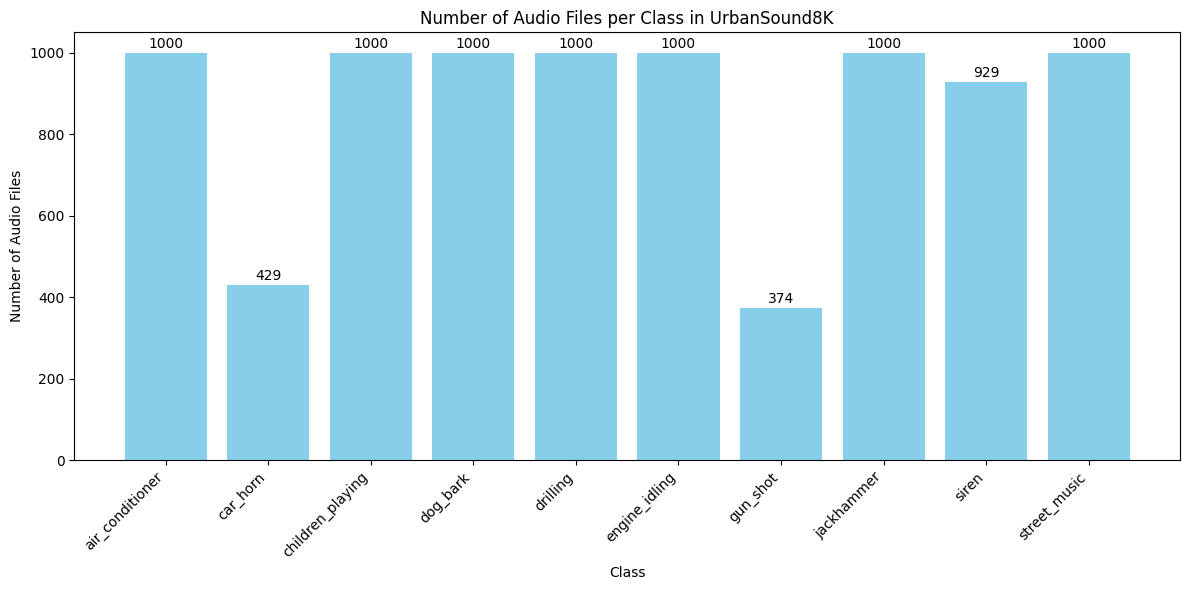




Class air_conditioner
Playing: C:\Users\Shaurya\.cache\kagglehub\datasets\chrisfilo\urbansound8k\versions\1\fold4\195969-0-0-7.wav


Plotting waveform...


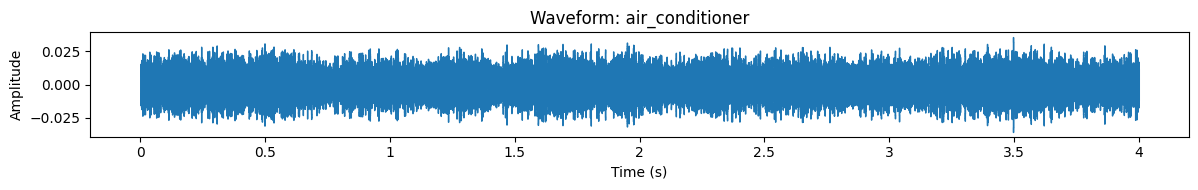

Plotting Mel-spectrogram...


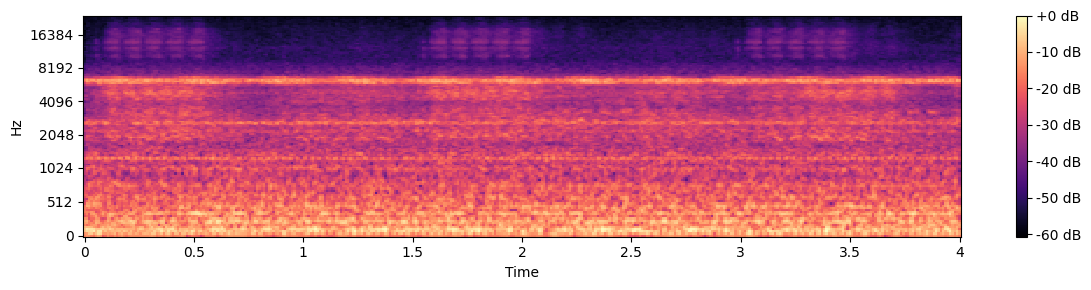




Class car_horn
Playing: C:\Users\Shaurya\.cache\kagglehub\datasets\chrisfilo\urbansound8k\versions\1\fold5\72259-1-5-2.wav


Plotting waveform...


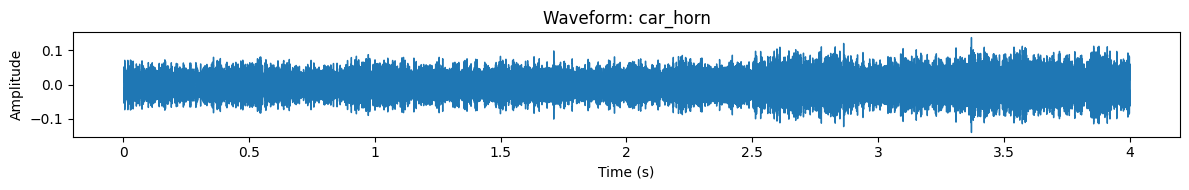

Plotting Mel-spectrogram...


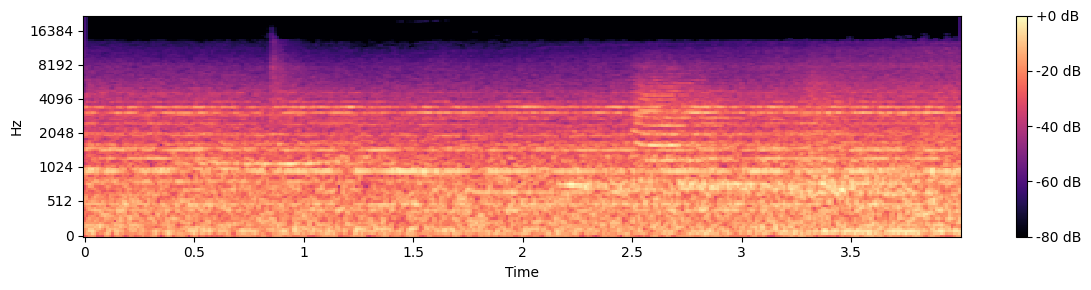




Class children_playing
Playing: C:\Users\Shaurya\.cache\kagglehub\datasets\chrisfilo\urbansound8k\versions\1\fold1\135776-2-0-49.wav


Plotting waveform...


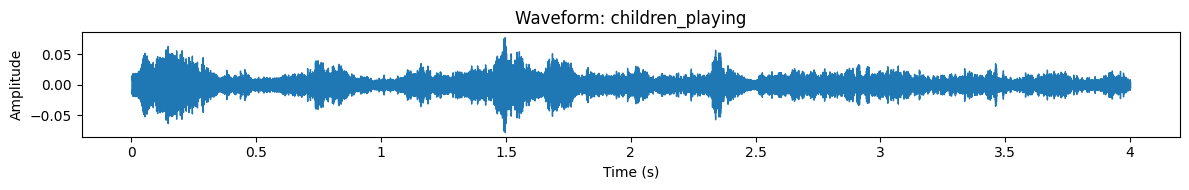

Plotting Mel-spectrogram...


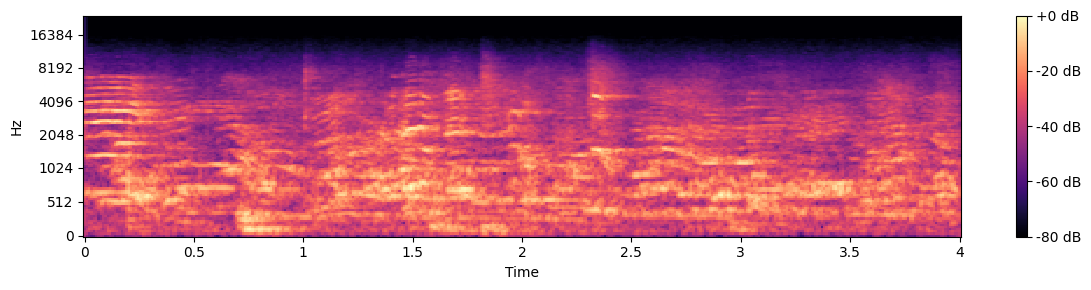




Class dog_bark
Playing: C:\Users\Shaurya\.cache\kagglehub\datasets\chrisfilo\urbansound8k\versions\1\fold2\23131-3-5-0.wav


Plotting waveform...


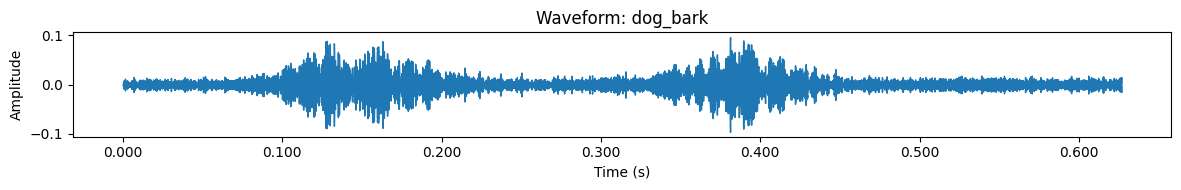

Plotting Mel-spectrogram...


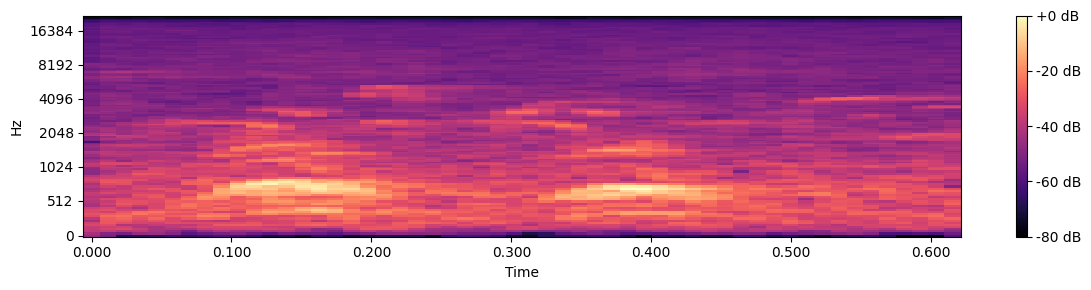




Class drilling
Playing: C:\Users\Shaurya\.cache\kagglehub\datasets\chrisfilo\urbansound8k\versions\1\fold3\185801-4-0-0.wav


Plotting waveform...


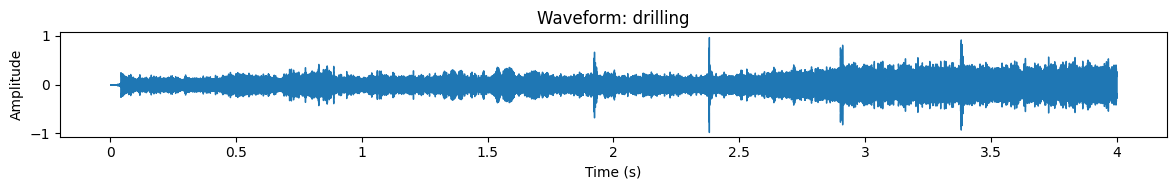

Plotting Mel-spectrogram...


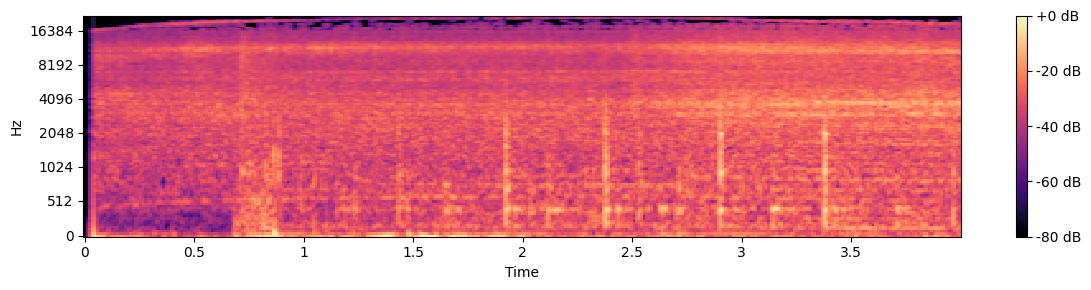




Class engine_idling
Playing: C:\Users\Shaurya\.cache\kagglehub\datasets\chrisfilo\urbansound8k\versions\1\fold7\168846-5-1-11.wav


Plotting waveform...


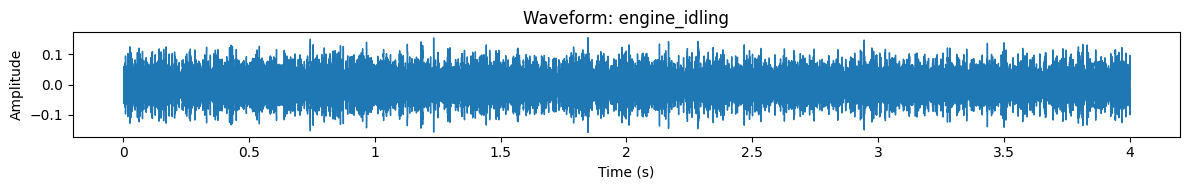

Plotting Mel-spectrogram...


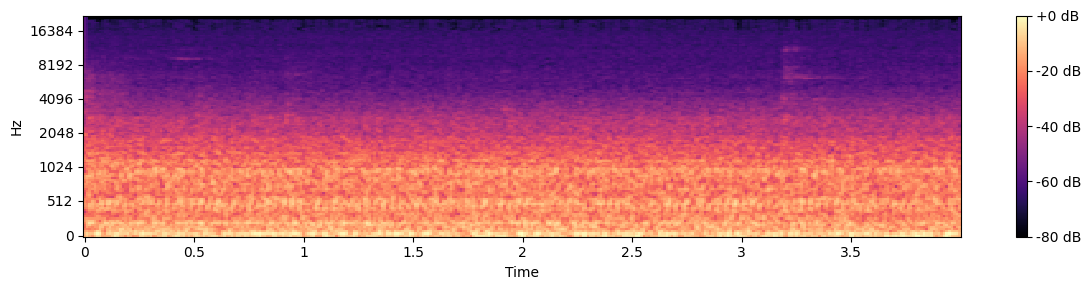




Class gun_shot
Playing: C:\Users\Shaurya\.cache\kagglehub\datasets\chrisfilo\urbansound8k\versions\1\fold3\135526-6-8-0.wav


Plotting waveform...


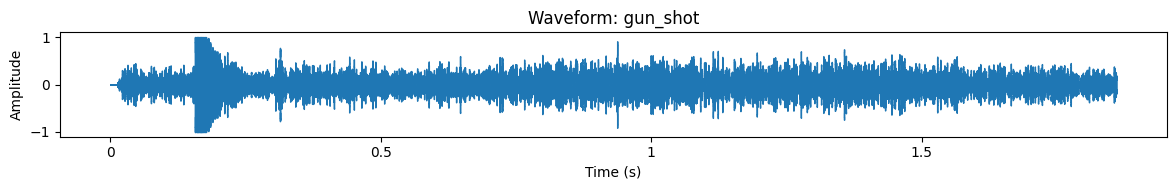

Plotting Mel-spectrogram...


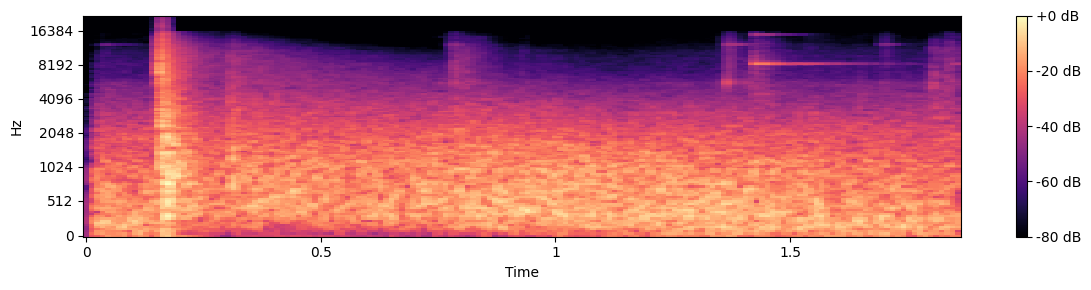




Class jackhammer
Playing: C:\Users\Shaurya\.cache\kagglehub\datasets\chrisfilo\urbansound8k\versions\1\fold1\180937-7-4-14.wav


Plotting waveform...


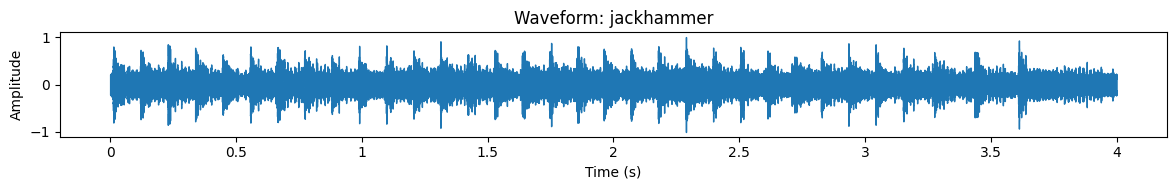

Plotting Mel-spectrogram...


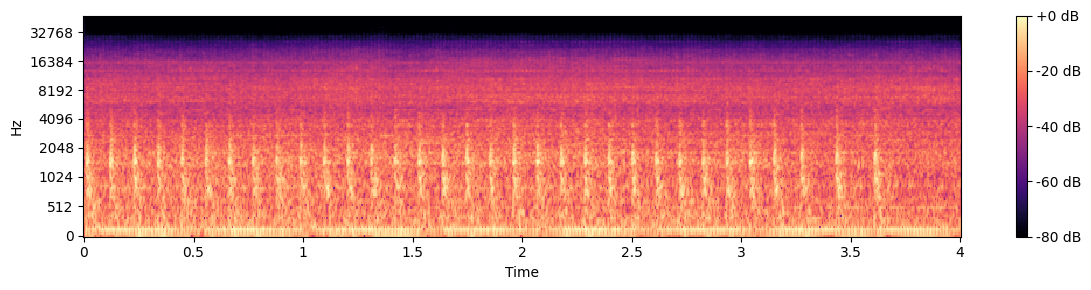




Class siren
Playing: C:\Users\Shaurya\.cache\kagglehub\datasets\chrisfilo\urbansound8k\versions\1\fold4\159752-8-0-2.wav


Plotting waveform...


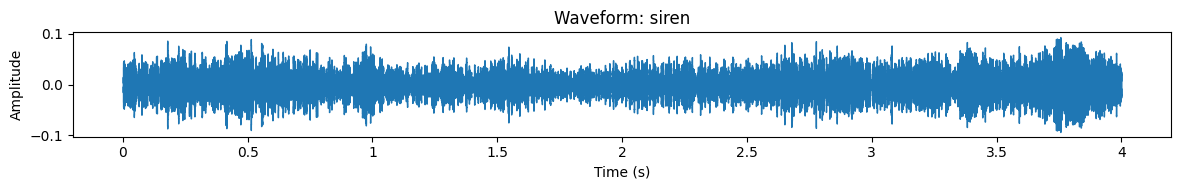

Plotting Mel-spectrogram...


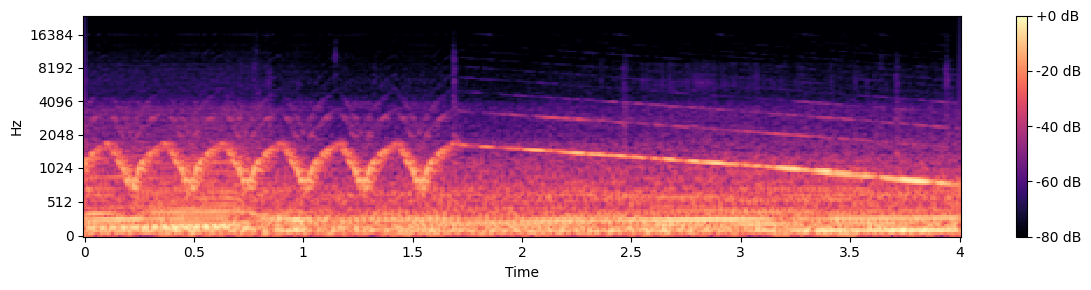




Class street_music
Playing: C:\Users\Shaurya\.cache\kagglehub\datasets\chrisfilo\urbansound8k\versions\1\fold7\157940-9-0-4.wav


Plotting waveform...


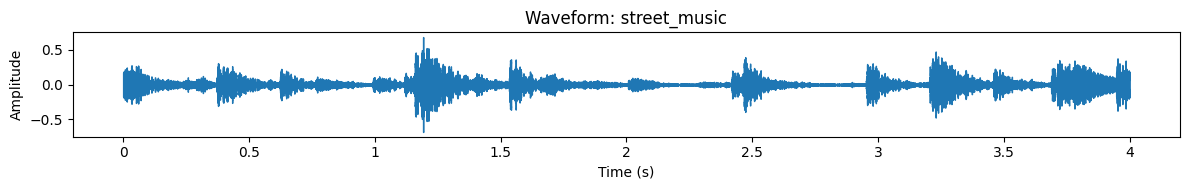

Plotting Mel-spectrogram...


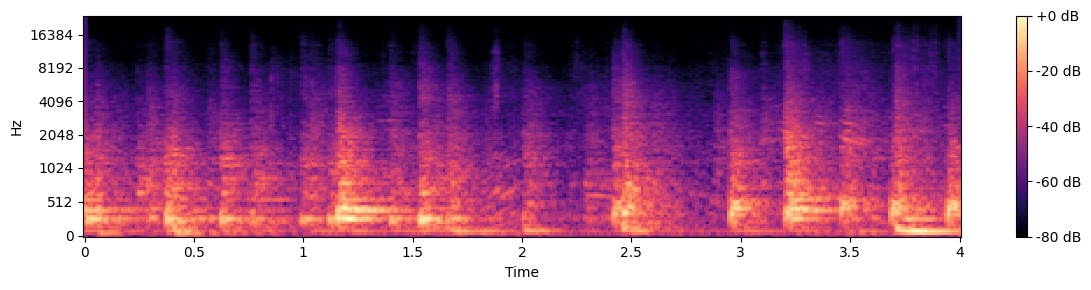

In [32]:

ubsound_clean = dataset_cleaning(ubsound8k_df, path)
display(ubsound_clean.head())
plot_files_per_class(ubsound_clean)
play_and_plot_random_per_class(ubsound_clean)
print_section()


# Preprocessing pipeline for data as per the requirements of the models 

In [6]:
# 1. Feature Extraction Functions

def get_features_classical(audio, sr):
    
    #Extracts MFCC, Chroma, and Spectral Contrast for classical ML.

    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
    mfcc_mean = mfcc.mean(axis=1)
    
    # Chroma
    chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
    chroma_mean = chroma.mean(axis=1)
    
    # Spectral Contrast 
    contrast = librosa.feature.spectral_contrast(y=audio, sr=sr)
    contrast_mean = contrast.mean(axis=1)
    
    return np.concatenate([mfcc_mean, chroma_mean, contrast_mean])

def get_features_cnn(audio, sr, target_size=(64, 64)):

    # mel_spec = librosa.feature.melspectrogram(
    #     y=audio, sr=sr, 
    #     n_fft=2048, 
    #     hop_length=512, 
    #     n_mels=128
    # )
    # mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    mel_spec_db = plot_mel_spectrogram(audio, sr, plot=False)

    # Resize to ensure all images are 128x128
    mel_resized = cv2.resize(mel_spec_db, target_size)
    
    # Normalize using min-max scaling
    mel_norm = (mel_resized - mel_resized.min()) / (mel_resized.max() - mel_resized.min() + 1e-6)
    
    return mel_norm

def get_features_kmeans(audio, sr):
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
    return mfcc.mean(axis=1)

# 2. Precompute All Features
def precompute_all_features(df):
    
    # Temporary lists
    storage = {
        "classical": [],
        "cnn": [],
        "kmeans": [],
        "labels": [],
        "folds": []
    }
    
    print("Starting feature extraction...")
    
    # Loop through the dataframe
    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        try:
            path = row['file_path']
            audio, sr = librosa.load(path, sr=22050)
            
            # 2. Extract and Store Features
            storage["classical"].append(get_features_classical(audio, sr))
            storage["cnn"].append(get_features_cnn(audio, sr))
            storage["kmeans"].append(get_features_kmeans(audio, sr))
            
            # 3. Store Metadata
            storage["labels"].append(row['classID'])
            storage["folds"].append(row['fold'])
            
        except Exception as e:
            print(f"Error processing {row['file_path']}: {e}")
            continue

    print("Feature extraction completed! Storing data according to folder, classID and model. ")
    
    # Convert to Numpy Arrays
    final_data = {
        "classical": np.array(storage["classical"]),
        "cnn": np.array(storage["cnn"]),
        "kmeans": np.array(storage["kmeans"]),
        "labels": np.array(storage["labels"]),
        "folds": np.array(storage["folds"])
    }
    # Reshape CNN features for compatibility
    final_data["cnn"] = final_data["cnn"][..., np.newaxis]
    
    print("Done! Datashape of features per model: ")
    print(f"Classical: {final_data['classical'].shape}")
    print(f"CNN:       {final_data['cnn'].shape}")
    print(f"KMeans:    {final_data['kmeans'].shape}")
    
    return final_data




# Initialising CNN

In [7]:
#CNN Model Training 
def create_cnn():
    model = models.Sequential([
        layers.InputLayer(input_shape=(64, 64, 1)),

        layers.Conv2D(64, (3,3), strides=1, padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.4),

        layers.Conv2D(128, (3,3), strides=1, padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(256, (3,3), strides=1, padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.3),

        layers.Conv2D(128, (3,3), strides=2, padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        
        layers.GlobalAveragePooling2D(),

        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),

        layers.Dense(128, activation='relu'),

        layers.Dense(10, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=4,
        restore_best_weights=True
    )

    return model, early_stopping




def get_train_test_from_memory(data_bundle, fold_idx, model_type):

    all_folds = data_bundle["folds"]
    all_labels = data_bundle["labels"]
    all_features = data_bundle[model_type]
    
    # Boolean Masking
    test_mask = (all_folds == fold_idx)
    train_mask = (all_folds != fold_idx)
    
    return (
        all_features[train_mask], all_labels[train_mask], 
        all_features[test_mask], all_labels[test_mask]
    )
    


In [8]:
# Pass your cleaned dataframe here
storage_bundle = precompute_all_features(ubsound_clean)

Starting feature extraction...


  0%|          | 0/8732 [00:00<?, ?it/s]

Feature extraction completed! Storing data according to folder, classID and model. 
Done! Datashape of features per model: 
Classical: (8732, 59)
CNN:       (8732, 64, 64, 1)
KMeans:    (8732, 40)


In [9]:
num_folds = 10

In [10]:
def metric_dict(y_true, y_pred): 
    metrics = { 
        "Accuracy": accuracy_score(y_true, y_pred), 
        "F1-Score": f1_score(y_true, y_pred, average="weighted") 
    } 
    return metrics

# Training CNN models

In [11]:
cnn_performance = []

# CHANGED: Iterate 1 to 10 folders
for fold in range(1, 11):
    print(f"\n" + "="*40)
    print(f"Running CNN Fold: {fold}")

    # Getting train and test data
    X_train_cnn, y_train, X_test_cnn, y_test = get_train_test_from_memory(
        storage_bundle, fold, "cnn"
    )

    # Safety Check: If fold is empty, skip
    if len(X_test_cnn) == 0:
        print(f"Fold {fold} is empty. Skipping.")
        continue

    # 2 Create Model
    # We create a fresh model for every fold to ensure no "data leakage" from previous folds
    model_cnn, early_stopping = create_cnn()

    # Only print summary for the first fold (to keep output clean)
    if fold == 1:
        print(model_cnn.summary())

    # 3. Train Model
    model_cnn.fit(
        X_train_cnn, y_train, 
        epochs=15, 
        validation_data=(X_test_cnn, y_test), 
        callbacks=[early_stopping], 
        verbose=1, 
        batch_size=32,
    )

    # 4. Predict
    y_pred_probs = model_cnn.predict(X_test_cnn)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # 5. Calculate Metrics
    metrics = metric_dict(y_test, y_pred)
    print(f"Fold {fold} Result -> Accuracy: {metrics['Accuracy']:.4f}")

    cnn_performance.append(metrics)

# --- Final Average Report ---
print("\n" + "="*40)
print("AVERAGE CNN PERFORMANCE (10-FOLD)")
avg_acc = np.mean([m['Accuracy'] for m in cnn_performance])
avg_f1 = np.mean([m['F1-Score'] for m in cnn_performance])

print(f"Average Accuracy: {avg_acc:.4f}")
print(f"Average F1-Score: {avg_f1:.4f}")



Running CNN Fold: 1


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 128)      │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 734,218 (2.80 MB)

 Trainable params: 733,066 (2.80 MB)

 Non-trainable params: 1,152 (4.50 KB)

None
Epoch 1/15
246/246 ━━━━━━━━━━━━━━━━━━━━ 45s 173ms/step - accuracy: 0.5199 - loss: 1.3460 - val_accuracy: 0.0401 - val_loss: 9.4700
Epoch 2/15
246/246 ━━━━━━━━━━━━━━━━━━━━ 43s 176ms/step - accuracy: 0.7374 - loss: 0.7784 - val_accuracy: 0.3265 - val_loss: 2.3227
Epoch 3/15
246/246 ━━━━━━━━━━━━━━━━━━━━ 43s 174ms/step - accuracy: 0.8007 - loss: 0.5830 - val_accuracy: 0.6380 - val_loss: 1.0996
Epoch 4/15
246/246 ━━━━━━━━━━━━━━━━━━━━ 42s 170ms/step - accuracy: 0.8497 - loss: 0.4543 - val_accuracy: 0.4444 - val_loss: 2.9573
Epoch 5/15
246/246 ━━━━━━━━━━━━━━━━━━━━ 43s 176ms/step - accuracy: 0.8726 - loss: 0.3889 - val_accuracy: 0.5544 - val_loss: 1.4309
Epoch 6/15
246/246 ━━━━━━━━━━━━━━━━━━━━ 43s 173ms/step - accuracy: 0.8899 - loss: 0.3303 - val_accuracy: 0.5074 - val_loss: 2.2077
Epoch 7/15
246/246 ━━━━━━━━━━━━━━━━━━━━ 44s 179ms/step - accuracy: 0.9047 - loss: 0.2880 - val_accuracy: 0.5178 - val_loss: 1.9980
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
Fold 1 Result -> Accuracy: 0.6380

Run

# Visualising metrics per fold 

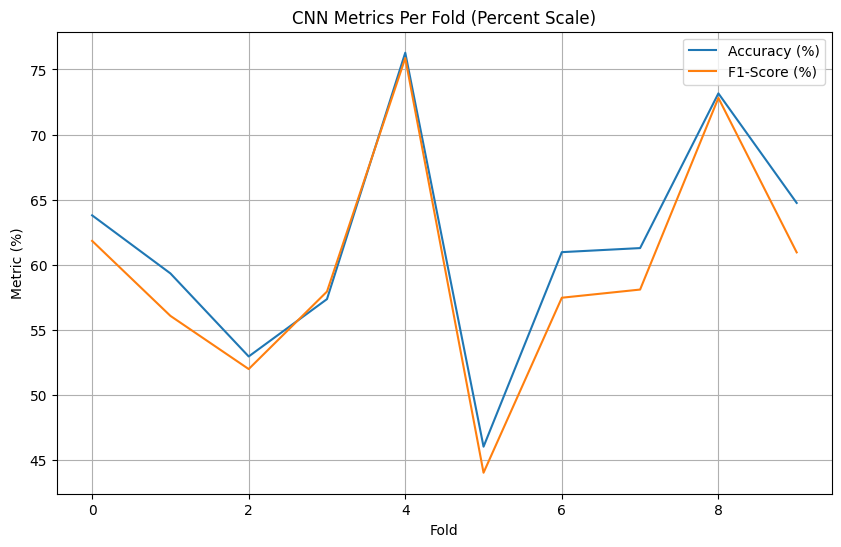


CNN Metrics Per Fold:
Fold 0:
Accuracy    63.802978
F1-Score    61.842802
----------------------------------------
Fold 1:
Accuracy    59.346847
F1-Score    56.088390
----------------------------------------
Fold 2:
Accuracy    52.972973
F1-Score    52.007362
----------------------------------------
Fold 3:
Accuracy    57.373737
F1-Score    57.953858
----------------------------------------
Fold 4:
Accuracy    76.282051
F1-Score    75.869588
----------------------------------------
Fold 5:
Accuracy    46.051033
F1-Score    44.051741
----------------------------------------
Fold 6:
Accuracy    60.978520
F1-Score    57.480706
----------------------------------------
Fold 7:
Accuracy    61.290323
F1-Score    58.107237
----------------------------------------
Fold 8:
Accuracy    73.161765
F1-Score    72.813973
----------------------------------------
Fold 9:
Accuracy    64.755078
F1-Score    60.961367
----------------------------------------

Average Metrics:


Accuracy  F1-Score
CNN  0.616015  0.597177

In [17]:
# ---- Compute average metrics ----
avg_metrics = {
    "Accuracy": np.mean([m["Accuracy"] for m in cnn_performance]),
    "F1-Score": np.mean([m["F1-Score"] for m in cnn_performance]),
}
cnn_performance_df = pd.DataFrame(cnn_performance)
# Transpose so folds are rows

# Convert raw decimals to percentages
cnn_performance_df = cnn_performance_df * 100

plt.figure(figsize=(10, 6))
plt.plot(cnn_performance_df.index, cnn_performance_df["Accuracy"], label="Accuracy (%)")
plt.plot(cnn_performance_df.index, cnn_performance_df["F1-Score"], label="F1-Score (%)")
plt.xlabel("Fold")
plt.ylabel("Metric (%)")
plt.title("CNN Metrics Per Fold (Percent Scale)")
plt.legend()
plt.grid(True)
plt.show()


avg_metrics_df = pd.DataFrame(avg_metrics, index=["CNN"])

print("\nCNN Metrics Per Fold:")
for i, row in cnn_performance_df.iterrows():
    print(f"Fold {i}:")
    print(row.to_string())
    print("-" * 40)


print("\nAverage Metrics:")
display(avg_metrics_df)

# Training Classical Models

In [ ]:
# Models
classical_models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel='rbf', random_state=42), 
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
}

results_classical = {} 

# 3. Main Loop
for model_name, model_type in classical_models.items():
    print("\n" + "="*30)
    print(f"Running 10-Fold for: {model_name}")

    fold_metrics = []

    # Iterate Folds 1 to 10
    for fold in range(1, 11):
        
        X_train, y_train, X_test, y_test = get_train_test_from_memory(
            storage_bundle, fold, "classical"
        )

        # Safety check: if a fold is empty, skip it
        if len(X_test) == 0:
            print(f"Fold {fold} empty, skipping.")
            continue
        
        model_type.fit(X_train, y_train)

        # Predict
        y_pred = model_type.predict(X_test)

        # Compute metrics
        metrics = metric_dict(y_test, y_pred)
        fold_metrics.append(metrics)

        print(f"Fold {fold} Accuracy: {metrics['Accuracy']:.4f}")

    # Aggregating Results
    avg_metrics_classical = {
        "Accuracy": np.mean([m["Accuracy"] for m in fold_metrics]),
        "F1-Score": np.mean([m["F1-Score"] for m in fold_metrics]),
    }

    results_classical[model_name] = {
        "Per Fold Metrics": fold_metrics,
        "Average Metrics": avg_metrics_classical,
    }

    print(f"\nAverage Metrics for {model_name}:")
    print(avg_metrics_classical) # CHANGED: Fixed variable name match
    new_row = pd.DataFrame(avg_metrics_classical, index=[model_name])

# Append using concat
    avg_metrics_df = pd.concat([avg_metrics_df, new_row])


Running 10-Fold for: Random Forest
Fold 1 Accuracy: 0.5659
Fold 2 Accuracy: 0.6137
Fold 3 Accuracy: 0.5697
Fold 4 Accuracy: 0.5909
Fold 5 Accuracy: 0.6720
Fold 6 Accuracy: 0.5772
Fold 7 Accuracy: 0.6181
Fold 8 Accuracy: 0.6179
Fold 9 Accuracy: 0.6581
Fold 10 Accuracy: 0.6428

Average Metrics for Random Forest:
{'Accuracy': np.float64(0.6126272153053103), 'F1-Score': np.float64(0.6024246739141915)}

Running 10-Fold for: SVM
Fold 1 Accuracy: 0.5578
Fold 2 Accuracy: 0.4966
Fold 3 Accuracy: 0.4800
Fold 4 Accuracy: 0.5970
Fold 5 Accuracy: 0.4455
Fold 6 Accuracy: 0.4860
Fold 7 Accuracy: 0.5430
Fold 8 Accuracy: 0.5980
Fold 9 Accuracy: 0.5049
Fold 10 Accuracy: 0.6033

Average Metrics for SVM:
{'Accuracy': np.float64(0.531219893396854), 'F1-Score': np.float64(0.5272680134328297)}

Running 10-Fold for: XGBoost
Fold 1 Accuracy: 0.6014
Fold 2 Accuracy: 0.6284
Fold 3 Accuracy: 0.5762
Fold 4 Accuracy: 0.6131
Fold 5 Accuracy: 0.6731
Fold 6 Accuracy: 0.5796
Fold 7 Accuracy: 0.6444
Fold 8 Accuracy: 0.

# Visualising and comparison of metrics in comparison to CNN

In [19]:
avg_metrics_df = avg_metrics_df[~avg_metrics_df.index.duplicated(keep='first')]
display(avg_metrics_df)



Accuracy  F1-Score
CNN            0.616015  0.597177
Random Forest  0.612627  0.602425
SVM            0.531220  0.527268
XGBoost        0.621518  0.610355

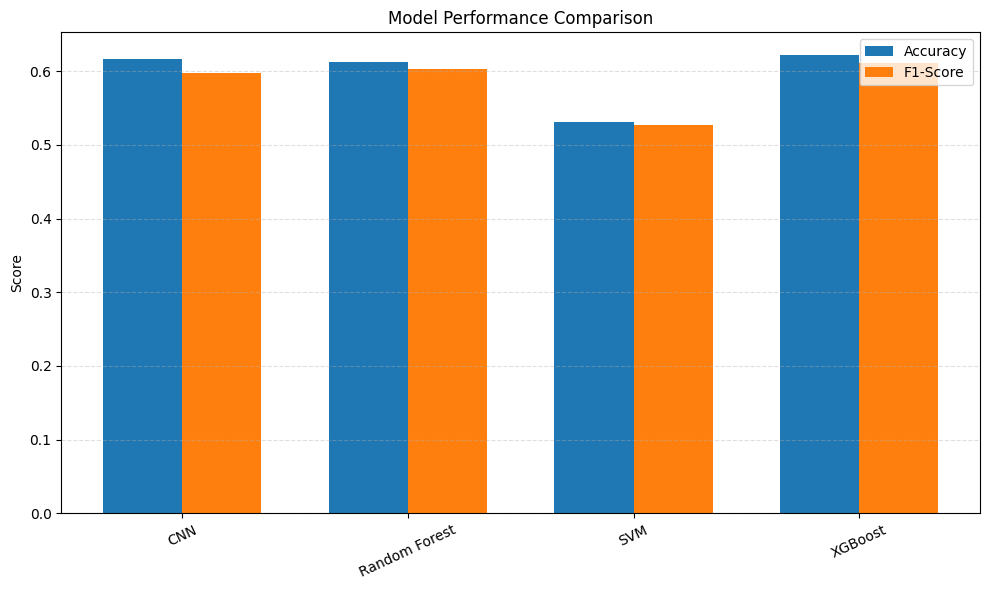

In [20]:
x = np.arange(len(avg_metrics_df.index))      # label positions
width = 0.35                    # bar width

plt.figure(figsize=(10, 6))

plt.bar(x - width/2, avg_metrics_df['Accuracy'], width, label="Accuracy")
plt.bar(x + width/2, avg_metrics_df['F1-Score'], width, label="F1-Score")
plt.xticks(x, avg_metrics_df.index, rotation=25)
plt.ylabel("Score")
plt.title("Model Performance Comparison")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

# Implementing K-Means Clustering

In [27]:
# Implementing K-Means 
def map_clusters_to_labels(y_true, cluster_labels, n_clusters):
    mapping = {}
    for c in range(n_clusters):
        mask = (cluster_labels == c)
        if np.sum(mask) == 0:
            mapping[c] = -1  # empty cluster
            continue
        
        # most common true label inside this cluster = assigned label
        most_common = np.bincount(y_true[mask]).argmax()
        mapping[c] = most_common
    
    mapped_preds = np.array([mapping[c] for c in cluster_labels])
    return mapped_preds

# ---------------------------------------------------------
# K-Means Parameters
# ---------------------------------------------------------
n_clusters = len(np.unique(storage_bundle["labels"]))
kmeans_model = KMeans(n_clusters=n_clusters, random_state=42)

results_kmeans = {}


# ---------------------------------------------------------
# 10-FOLD LOOP
# ---------------------------------------------------------
print("\n" + "="*40)
print("Running 10-Fold K-Means Clustering")

fold_metrics = []

for fold in range(1, 11):
    print(f"\nFold {fold}")
    
    # Load train/test split
    X_train, y_train, X_test, y_test = get_train_test_from_memory(
        storage_bundle, fold, "kmeans"
    )

    if len(X_test) == 0:
        print(f"Fold {fold} empty, skipping.")
        continue

    # -----------------------------------------------------
    # Fit K-Means on TRAIN data (unsupervised)
    # -----------------------------------------------------
    kmeans_model.fit(X_train)

    # Predict clusters for test data
    cluster_preds = kmeans_model.predict(X_test)

    # Map clusters → labels using majority voting
    y_pred = map_clusters_to_labels(y_test, cluster_preds, n_clusters)

    # -----------------------------------------------------
    # Compute metrics
    # -----------------------------------------------------
    metrics = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred, average="weighted")
    }

    fold_metrics.append(metrics)
    print(f"Fold {fold} Accuracy: {metrics['Accuracy']:.4f}")


# ---------------------------------------------------------
# AVERAGE METRICS
# ---------------------------------------------------------
avg_metrics_kmeans = {
    "Accuracy": np.mean([m["Accuracy"] for m in fold_metrics]),
    "F1-Score": np.mean([m["F1-Score"] for m in fold_metrics])
}

results_kmeans["K-Means"] = {
    "Per Fold Metrics": fold_metrics,
    "Average Metrics": avg_metrics_kmeans
}

print("\n" + "="*40)
print("Average K-Means Metrics:")
print(avg_metrics_kmeans)

# Add to your summary dataframe
kmeans_row = pd.DataFrame(avg_metrics_kmeans, index=["K-Means"])
avg_metrics_df = pd.concat([avg_metrics_df, kmeans_row])



Running 10-Fold K-Means Clustering

Fold 1
Fold 1 Accuracy: 0.4318

Fold 2
Fold 2 Accuracy: 0.3885

Fold 3
Fold 3 Accuracy: 0.3643

Fold 4
Fold 4 Accuracy: 0.3010

Fold 5
Fold 5 Accuracy: 0.3793

Fold 6
Fold 6 Accuracy: 0.3742

Fold 7
Fold 7 Accuracy: 0.3496

Fold 8
Fold 8 Accuracy: 0.4206

Fold 9
Fold 9 Accuracy: 0.4350

Fold 10
Fold 10 Accuracy: 0.3226

Average K-Means Metrics:
{'Accuracy': np.float64(0.37670734447440535), 'F1-Score': np.float64(0.32123320960223456)}


# Visualisation of number of clusters based on PCA-analysis


Average K-Means Metrics:
{'Accuracy': np.float64(0.37670734447440535), 'F1-Score': np.float64(0.32123320960223456)}


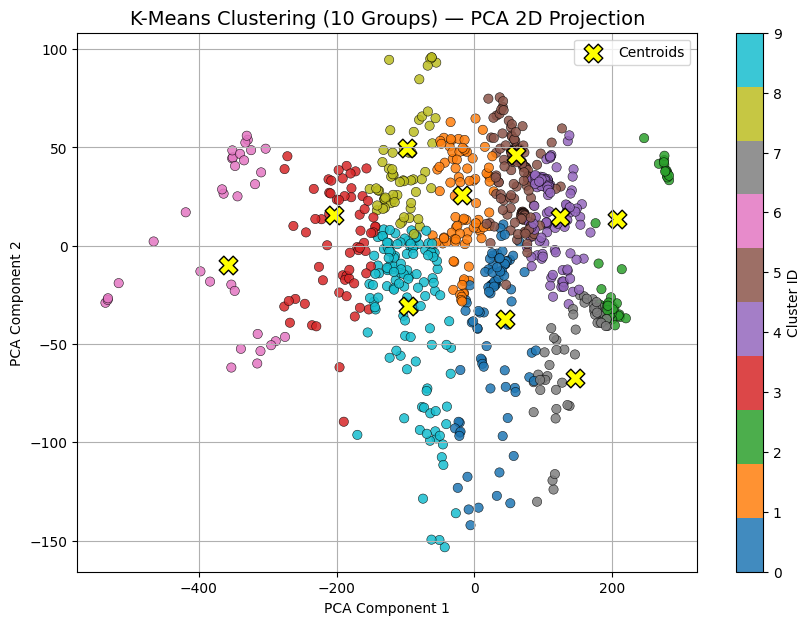

In [30]:
print("\n" + "="*40)
print("Average K-Means Metrics:")
print(avg_metrics_kmeans)

# ============================================
# K-MEANS VISUALISATION (ADD THIS PART)
# ============================================

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce TEST data to 2D
pca = PCA(n_components=2)
X_test_2d = pca.fit_transform(X_test)

# Plot K-Means clusters (10 groups)
plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    X_test_2d[:, 0],
    X_test_2d[:, 1],
    c=cluster_preds,        # color by cluster ID (0–9)
    cmap="tab10",
    s=45,
    alpha=0.85,
    edgecolors='black',
    linewidths=0.4
)

# Add centroids
centroids_2d = pca.transform(kmeans_model.cluster_centers_)
plt.scatter(
    centroids_2d[:, 0],
    centroids_2d[:, 1],
    c="yellow",
    s=180,
    edgecolors='black',
    marker="X",
    label="Centroids"
)

plt.title("K-Means Clustering (10 Groups) — PCA 2D Projection", fontsize=14)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(scatter, label="Cluster ID")
plt.legend()
plt.grid(True)
plt.show()

# ============================================

# Add to summary dataframe
kmeans_row = pd.DataFrame(avg_metrics_kmeans, index=["K-Means"])
avg_metrics_df = pd.concat([avg_metrics_df, kmeans_row])

# Visualisation of metrics of K means in comparison to other models

Accuracy   F1-Score
CNN            61.601530  59.717702
Random Forest  61.262722  60.242467
SVM            53.121989  52.726801
XGBoost        62.151843  61.035505
K-Means        37.670734  32.123321

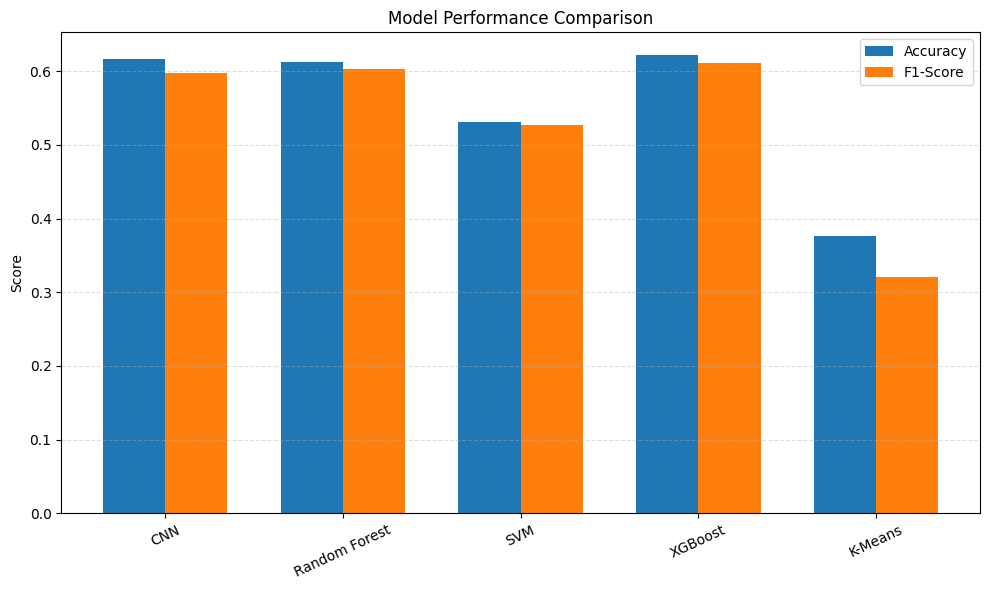

In [31]:
avg_metrics_df = avg_metrics_df[~avg_metrics_df.index.duplicated(keep='first')]

display(avg_metrics_df * 100)

x = np.arange(len(avg_metrics_df.index))      # label positions
width = 0.35                    # bar width

plt.figure(figsize=(10, 6))

plt.bar(x - width/2, avg_metrics_df['Accuracy'], width, label="Accuracy")
plt.bar(x + width/2, avg_metrics_df['F1-Score'], width, label="F1-Score")
plt.xticks(x, avg_metrics_df.index, rotation=25)
plt.ylabel("Score")
plt.title("Model Performance Comparison")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

# SHAP Analysis

Starting SHAP Analysis...
Classes: ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']
Initializing SHAP GradientExplainer...
Explainer initialized successfully.
Computing SHAP values for 10 test samples...

Generating SHAP Image Plot...
(Red pixels increase probability of the class, Blue pixels decrease it)


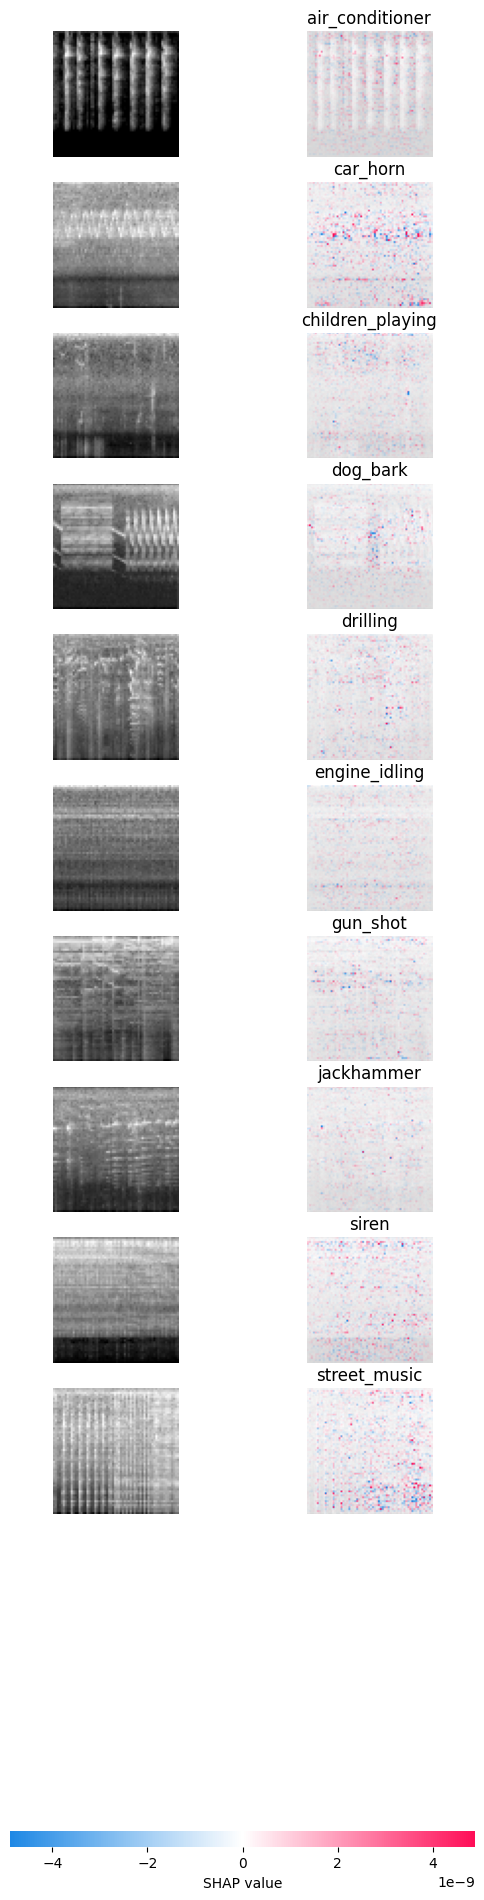


Global Mean Importance per Class (Average Absolute SHAP Value):


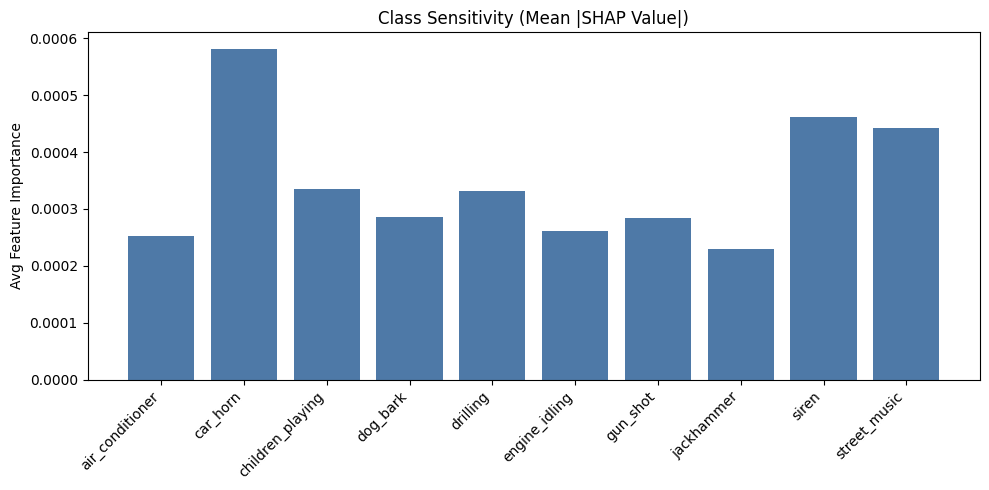


Prediction analysis for explained samples:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Sample Index        True Class  Predicted Class Confidence
0           661          dog_bark         dog_bark    100.00%
1           792             siren            siren     42.45%
2           511  children_playing    engine_idling     85.99%
3           222             siren            siren     97.89%
4           293  children_playing     street_music     70.39%
5           188     engine_idling  air_conditioner     96.34%
6           298      street_music     street_music     97.27%
7           556  children_playing     street_music     98.30%
8           534     engine_idling     street_music     91.33%
9           274        jackhammer       jackhammer     95.94%

In [24]:
#SHAP Analysis
import shap
print("Starting SHAP Analysis...")


# -------------------------
# 1. Retrieve Class Names
# -------------------------
if 'ubsound_clean' in locals():
    class_map = ubsound_clean[['classID', 'class']].drop_duplicates().sort_values('classID')
    class_names = class_map['class'].tolist()
else:
    print("Warning: 'ubsound_clean' not found. Using generic class names.")
    class_names = [f"Class {i}" for i in range(10)]

print(f"Classes: {class_names}")

# -------------------------
# 2. Prepare CNN Data
# -------------------------
def ensure_cnn_shape(X):
    """Ensure input is 64x64x1, reshaping if needed."""
    if X.ndim == 2:  # flattened data
        n_samples = X.shape[0]
        expected_size = 64 * 64
        if X.shape[1] % expected_size != 0:
            raise ValueError(f"Cannot reshape {X.shape[1]} features into 64x64x1")
        X = X.reshape(n_samples, 64, 64, 1)
    elif X.ndim == 3:
        X = X[..., np.newaxis]  # add channel if missing
    return X

if 'X_train_cnn' in locals() and 'model_cnn' in locals():
    X_train_cnn = ensure_cnn_shape(X_train_cnn)
    
    n_background = min(100, len(X_train_cnn))
    background_indices = np.random.choice(len(X_train_cnn), n_background, replace=False)
    background = X_train_cnn[background_indices]

    # -------------------------
    # 3. Initialize SHAP Explainer
    # -------------------------
    print("Initializing SHAP GradientExplainer...")
    explainer = shap.GradientExplainer(model_cnn, background)
    print("Explainer initialized successfully.")

    # -------------------------
    # 4. Compute SHAP Values
    # -------------------------
    if 'X_test_cnn' in locals():
            X_test_cnn = ensure_cnn_shape(X_test_cnn)
            n_explain = min(10, len(X_test_cnn))
            test_indices = np.random.choice(len(X_test_cnn), n_explain, replace=False)
            test_samples = X_test_cnn[test_indices]

            test_labels = y_test[test_indices] if 'y_test' in locals() else [None] * n_explain

            print(f"Computing SHAP values for {n_explain} test samples...")
            shap_values = explainer.shap_values(test_samples)

            # -------------------------
            # 5. SHAP Image Plot
            # -------------------------
            print("\nGenerating SHAP Image Plot...")
            print("(Red pixels increase probability of the class, Blue pixels decrease it)")
            shap.image_plot(shap_values, test_samples, labels=class_names)

            # -------------------------
            # 6. Global Feature Importance
            # -------------------------
            print("\nGlobal Mean Importance per Class (Average Absolute SHAP Value):")
            class_impacts = [np.mean(np.abs(sv)) for sv in shap_values]

            plt.figure(figsize=(10, 5))
            plt.bar(class_names, class_impacts, color='#4e79a7')
            plt.title("Class Sensitivity (Mean |SHAP Value|)")
            plt.ylabel("Avg Feature Importance")
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()

            # -------------------------
            # 7. Prediction Table
            # -------------------------
            print("\nPrediction analysis for explained samples:")
            preds = model_cnn.predict(test_samples)

            results_list = []
            for i in range(n_explain):
                pred_idx = np.argmax(preds[i])
                confidence = preds[i][pred_idx]
                true_lbl = class_names[test_labels[i]] if test_labels[i] is not None else "Unknown"
                pred_lbl = class_names[pred_idx]
                results_list.append({
                    "Sample Index": test_indices[i],
                    "True Class": true_lbl,
                    "Predicted Class": pred_lbl,
                    "Confidence": f"{confidence:.2%}"
                })

            display(pd.DataFrame(results_list))

    else:
        print("Error: 'X_test_cnn' not found.")



else:
    print("Error: 'X_train_cnn' or 'model_cnn' not found. Please run training first.")



# Summary 
## Data Preprocessing
Data preprocessing consisted of several steps : 
- Cleaning and editing the original metaData file, which included removing irrelevant columns like salience, start, end and fsID, also adding a column named "filepath" which uses original dataset folder filepath and filenames to construct a filepath for each file in the urbansound8k.csv file. 
- For Classical Models, we extracted MFCC features from the audio files using librosa library. 
- For Deep Learning Model we extracted spectrogram features from the audio files using librosa library. 
## Data storage
Data like features, spectograms are all generated for all files and stored in a list of numpy arrays, all properly mapped to its folder and class. This data is split and trained on models instead of manually generating these features each loop of the 10-fold cross-validation. 
## Data Splitting
Data was split using a cross-validation method, where for each fold, the target folder is used as the test set and the remaining folders are used as the training set, also called the 10-fold cross-validation. 
## Model Training
- Classical models like SVM, Random Forest and XGBoost were trained using the extracted features. 
- A custom CNN model was created and trained using the spectogram 
## Model Evaluation
- The best performing models were XGBoost and CNN with 61.26% and 61.6% accuracies respectively. Models like K-Means clustering failed to achieve a proper level of accuracy and werent able to properly classify the audio files as evident in its Visualisation.
## SHAP Analysis
The SHAP analysis shows how strongly the CNN relies on different classes. *Car horn* exhibited the highest average SHAP value, meaning the model found it highly distinctive, likely due to its sharp and repetitive spectral pattern. *Siren* and *street_music* also exhibited high SHAP values, suggesting that their frequency modulations and structured melodic components, providing good classification. Mid-range classes like children_playing, drilling, and gun_shot exhibited moderate SHAP values, reflecting partially overlapping acoustic signatures. Lower-importance classes such as air_conditioner and jackhammer exhibited low SHAP values, indicating that these sounds share more uniform patterns, therefore not giving thr model enough unique features to train on.